In [4]:
# IMPORTS :

## Plots and data manipulation : 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Préprocessing : 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [5]:
recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [6]:
columns_quanti = ['age', 'imc', 'g', 'p', 'sf.dsm.eva', 'sf.dsp.eva']

# Reduction dimensionnelle FAMD : 

## Préparation des données : 

In [7]:
rows_recueil_imc, columns_recueil_imc = recueil_imc.shape
print(f'Le fichier recueil_imc, contient {rows_recueil_imc} lignes (patientes) et {columns_recueil_imc} colonnes (pathologies)')

# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')

Le fichier recueil_imc, contient 181 lignes (patientes) et 90 colonnes (pathologies)


/tmp/ipykernel_17885/2459541935.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


In [8]:
recueil_imc.dropna(axis=0, inplace=True)
# Dernières 4 colonnes contiennent le target (endometriose)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

In [9]:
features.shape

(83, 73)

### Baseline : le moins de changement possible

In [10]:
def tri_colonnes_features(features):
    # Tri des colonnes : 
    ## On extrait la liste des colonnes du DF :
    columns = list(features.columns)
    ## Création des listes des colonnes : 
    columns_str = []
    columns_float = []
    columns_datetime = []
    ## Boucle pour trier les colonnes :
    for col in columns:
        if features.loc[:,col].dtypes == 'object':
            columns_str.append(col)
        elif features.loc[:,col].dtypes == 'float64' or features.loc[:,col].dtypes == 'int64' :
            columns_float.append(col)
        elif features.loc[:,col].dtypes == 'datetime64[ns]':
            columns_datetime.append(col)
        else:
            print('Colonne non triée :',col)
    columns_quanti = ['age', 'imc', 'g', 'p', 'sf.dsm.eva', 'sf.dsp.eva']
    for col in columns_quanti:
        columns_float.remove(col)
    columns_float
    
    return columns_str, columns_float, columns_datetime


In [11]:
columns_str, column_cat_float, columns_datetime = tri_colonnes_features(features)

In [12]:
def preprocess(features, baseline=True):
    
    columns_quanti = ['age', 'imc', 'g', 'p', 'sf.dsm.eva', 'sf.dsp.eva']
    columns_str, column_cat_float, columns_datetime = tri_colonnes_features(features)
    features.drop(columns_datetime, axis=1, inplace=True)
    if baseline:
        features[column_cat_float] = features[column_cat_float].astype('object')
        features.loc[:,column_cat_float].replace([1.0,0.0], ['positif','negatif'], inplace=True)
        cat = columns_str + column_cat_float
        features_cat = features.loc[:,cat].copy()
        features_cont = features.loc[:,columns_quanti].copy()
        
    else:
        features_chir_dsptype = pd.get_dummies(features.loc[:,['chir','sf.dsp.type']]).replace([1,0], ['positif','negatif'])
        features[column_cat_float] = features[column_cat_float].astype('object')
        features.loc[:,column_cat_float] = features.loc[:,column_cat_float].replace([1.0,0.0], ['positif','negatif'])
        cat = columns_str + column_cat_float
        features_cat = pd.concat([features_chir_dsptype, features.loc[:,cat]], axis=1)
        features_cont = features.loc[:,columns_quanti].copy()

    return features_cat, features_cont

In [13]:
features.head(4)

,chir,age,imc,g,p,atcd.endo,atcd.chir.oma,atcd.fibrome,atcd.chir.endo,atcd.infertilite,...,irm.vagin,irm.kissing,irm.adherences,irm.retroversion,irm.epanchement,irm.opac.vagin,irm.opac.rectum,irm.xr,irm.externe,avis.dig/uro
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
JJ-002,SW,36,21.6,5,3,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0
VH-014,GD,37,19.1,0,0,1,0,0,0,1,...,1,0,1,0,0,1,1,1,0,1
DS-015,SW,49,19.1,2,2,1,1,0,1,0,...,0,0,0,0,0,1,1,1,0,1
GC-021,CAP,42,35.4,4,0,0,1,0,0,1,...,0,0,1,0,0,1,1,1,0,0


In [14]:
#On crée les deux versions des dataframes (ONE_enc, ou inchangé)
features_cat_enc, features_cont = preprocess(features, baseline=True)
features_cat_enc_2, features_cont_2 = preprocess(features, baseline=False)

In [15]:
def Binarisation(x):
    if x>1:
        x=1
    return x
endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
endometriose.replace([1.0,0.0], ['positif', 'négatif'], inplace=True)

In [16]:
scaler = StandardScaler()
features_cont = pd.DataFrame(scaler.fit_transform(features_cont), columns=columns_quanti, index=features_cont.index)
features_cont_2 = pd.DataFrame(scaler.fit_transform(features_cont_2), columns=columns_quanti, index=features_cont_2.index)
features_cont.head(4)

,age,imc,g,p,sf.dsm.eva,sf.dsp.eva
Numéro anonymat,,,,,,
JJ-002,0.224571,-0.446131,1.965298,2.336349,0.252027,-0.071688
VH-014,0.364717,-0.981851,-0.623904,-0.677905,-0.234444,-0.071688
DS-015,2.046468,-0.981851,0.411777,1.331598,-0.234444,0.978337
GC-021,1.065447,2.511038,1.447458,-0.677905,1.224969,1.328346


# PCA : head

## Initialisation des méthodes

In [17]:
def df_corvar(corvar, pca, axe1, axe2, slicer=5):
    
    df = pd.concat([pd.DataFrame(corvar[:,axe1]), pd.DataFrame(corvar[:,axe2])], axis=1)
    df.index=pca.feature_names_in_
    df.columns=[str(axe1), str(axe2)]
    df['norme']= np.sqrt(pow(df[str(axe1)],2)+pow(df[str(axe2)],2))
    df.columns = [f'Axe {axe1+1}', f'Axe {axe2+1}', 'Norme']
    df.sort_values(by='Norme', ascending=False, inplace=True)
    return df[:slicer]

class DontChangeAnything(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self

    def transform(self, X):
        return X

In [18]:
def make_df_acp(acp):
    df_acp = pd.DataFrame(acp.components_, columns=acp.feature_names_in_, index=acp.get_feature_names_out()).T
    return df_acp

def make_df_results(acp_fitted_transformed, acp, X):
    df_results = pd.DataFrame(acp_fitted_transformed, columns=acp.get_feature_names_out(), index=X.index)
    return df_results

In [28]:
def plot_pca(X_fitted, X, Y, pca, axe_i:int, axe_j:int, save:bool, ONE=False):
    
    '''
    Allow to plot(2D) PCA results.
    Inputs:
    ------------------
    pca : the pca fitted and transformed on your data
    
    axe_i (int) : first axe that you show (0 to n_components)
    axe_j (int) : second axe that you show (0 to n_components)
    
    Return : 
    -------------------
    None
    '''
    
    corvar_ = make_df_acp(pca)
    results = make_df_results(X_fitted, pca, X)
    n, p = X_fitted.shape
    n1, p2 = X.shape
    fig = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot(121)

    # taille figure
    # fig, ax = plt.subplots(figsize=(7,7))
    ax1.set_xlim(-5,5) #même limites en abscisse
    ax1.set_ylim(-5,5) #et en ordonnée

    # nuage de points des individus / observations
    colormap=['b','r']
    Y_array = np.array(Y)
   # scatter = plt.scatter(results.iloc[:,axe_i],results.iloc[:,axe_j],c=Y_array, cmap='Accent', s=2.0)
    scatter = sns.scatterplot(y = results.iloc[:,axe_j], x = results.iloc[:,axe_i], hue=Y, palette='rocket')

    # noms des axes et de la figure
    ax1.set_title(f"Nuage des individus / observations (Axes {axe_i} et {axe_j} : {round((pca.explained_variance_ratio_[axe_i]+ pca.explained_variance_ratio_[axe_j])*100,2)}%)", size=12)
    ax1.set_xlabel(f"{axe_i} : {round(pca.explained_variance_ratio_[axe_i]*100,2)}% de variance expliquée", size=10)
    ax1.set_ylabel(f"{axe_j} : {round(pca.explained_variance_ratio_[axe_j]*100,2)}% de variance expliquée", size=10)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=labels)

    #ajouter les axes # a preciser
    plt.plot([-10,10],[0,0],color='black',linestyle='-',linewidth=1)
    plt.plot([0,0],[-10,10],color='black',linestyle='-',linewidth=1)

    # plt.legend(#handles=scatter.legend_elements()[0], 
    #           labels=Y,
    #           title="Endométriose :")

    ax2 = plt.subplot(122)

    #racine carrée des valeurs propres
    sqrt_eigval = np.sqrt(pca.explained_variance_)

    #corrélation des variables avec les axes
    corvar = np.zeros((p2,p)) #on veut : (86,99)

    for k in range(p):
        corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k] 
    corvar_top5 = df_corvar(corvar,pca, axe_i, axe_j)

    #cercle des corrélations
    # Axes 1/3
    #fig, ax = plt.subplots(figsize=(8,8))
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

    #affichage des étiquettes (noms des variables)
    for j in range(corvar_top5.shape[0]):
        plt.annotate(corvar_top5.index[j],(corvar_top5.iloc[j,0],corvar_top5.iloc[j,1]))

    #ajouter les axes
    plt.plot([-1,1],[0,0],color='black',linestyle='-',linewidth=1)
    plt.plot([0,0],[-1,1],color='black',linestyle='-',linewidth=1)

    # noms des axes et de la figure
    ax2.set_title(f"Cercle des corrélations des variables (Axes {axe_i} et {axe_j} : {round((pca.explained_variance_ratio_[axe_i]+acp.explained_variance_ratio_[axe_j])*100,2)}%)", size=12)
    ax2.set_xlabel(f"{axe_i} : {round(pca.explained_variance_ratio_[axe_i]*100,2)}% de variance expliquée", size=10)
    ax2.set_ylabel(f"{axe_j} : {round(pca.explained_variance_ratio_[axe_j]*100,2)}% de variance expliquée", size=10)

    #ajouter un cercle
    cercle = plt.Circle((0,0),1,color='blue',fill=False)
    ax2.add_artist(cercle) 

    # affichage des étiquettes (noms des variables)
    from matplotlib.patches import ConnectionPatch

    for j in range(corvar_top5.shape[0]):
        arr = ConnectionPatch((0,0),(corvar_top5.iloc[j,0],corvar_top5.iloc[j,1]),
            coordsA = "data", coordsB = "data",arrowstyle="->")
        ax2.add_artist(arr)

    #affichage
    if save ==True :
        if ONE == True:
            plt.savefig(f'Data/Figures/PCA/PCA_ONE_axe{axe_i}_vs_axe{axe_j}')
        else:
            plt.savefig(f'Data/Figures/PCA/PCA_axe{axe_i}_vs_axe{axe_j}')
    else:
        plt.show();

## Lancer PCA :  

In [29]:
#chargement données
X = features_cont
Y = endometriose

#nombre d'observations
n = X.shape[0]

#nombre de variables
p = X.shape[1]
print(p, "variables mises dans l'ACP")


#acp
acp = PCA(n_components=p ,svd_solver='full')
coord = acp.fit_transform(X, Y)
print("Valeurs propres des axes : ")
print(pd.DataFrame(np.round(acp.explained_variance_,2)).head(10))

# % de variance expliquée pour chacun des axes
acp.explained_variance_ratio_*100

6 variables mises dans l'ACP
Valeurs propres des axes : 
      0
0  2.33
1  1.29
2  1.02
3  0.69
4  0.54
5  0.21


array([38.38486175, 21.24772295, 16.76596956, 11.29716111,  8.86720857,
        3.43707606])

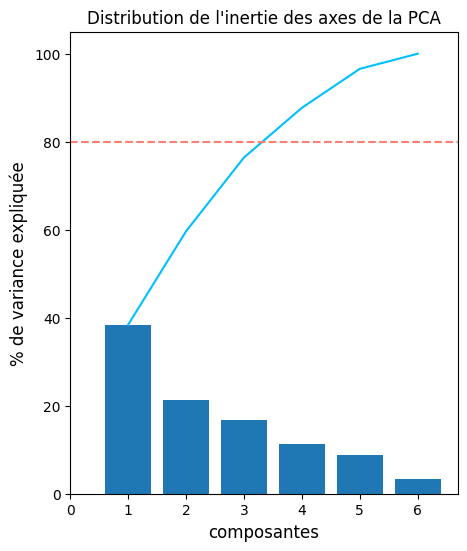

In [30]:
# ébouli des valeurs propres 
fig, ax = plt.subplots(figsize = (5, 6))
rects = ax.bar(range(1,p+1),acp.explained_variance_ratio_*100) # range(1,n_variables+1)

ax.set(title='Distribution de l\'inertie des axes de la PCA')
ax.set_xlabel("composantes", size=12)
ax.set_ylabel("% de variance expliquée", size=12)
plt.plot(
    range(1,len(acp.explained_variance_ )+1),
    (acp.explained_variance_ratio_*100).cumsum(),
    c='deepskyblue',
    label='Cumulative Explained Variance')
plt.xticks(list(range(len(acp.explained_variance_ )+1)))
plt.axhline(y=80, xmin=0, xmax=1.0, color='salmon', linestyle='--')
plt.savefig('Data/Figures/PCA/PCA_full_dataset_distrib_axes.png')

In [31]:
acp.explained_variance_

array([2.33117819, 1.29041049, 1.01822596, 0.68609588, 0.53852072,
       0.2087395 ])

## Axe pca0 vs pca1 :

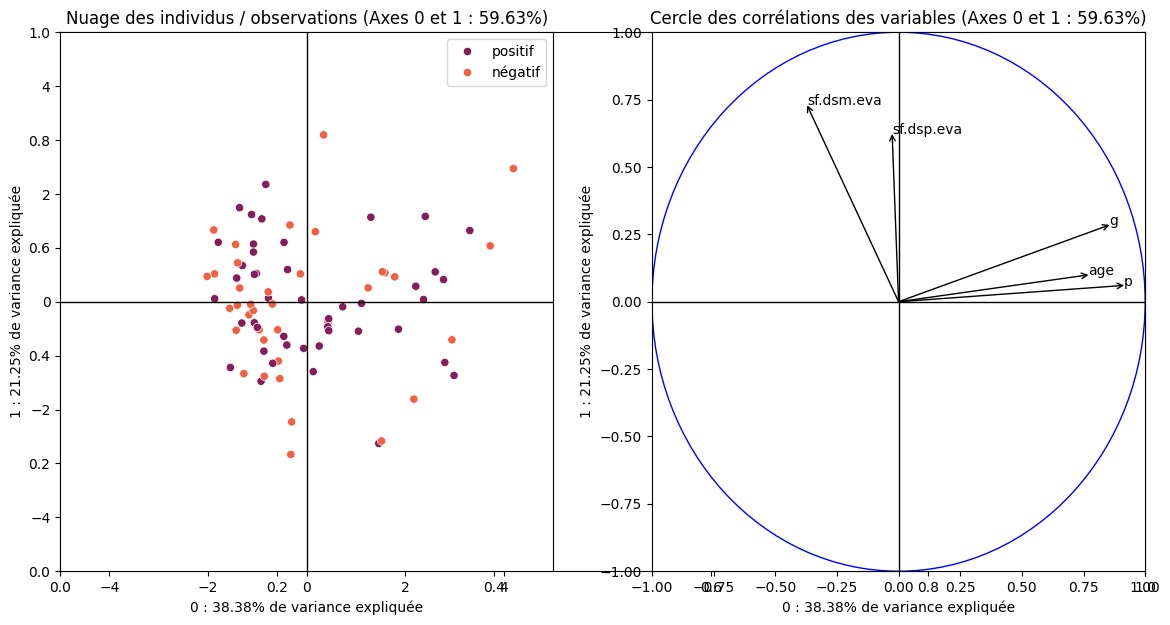

In [32]:
plot_pca(coord, X, Y, acp, 0, 1, True)

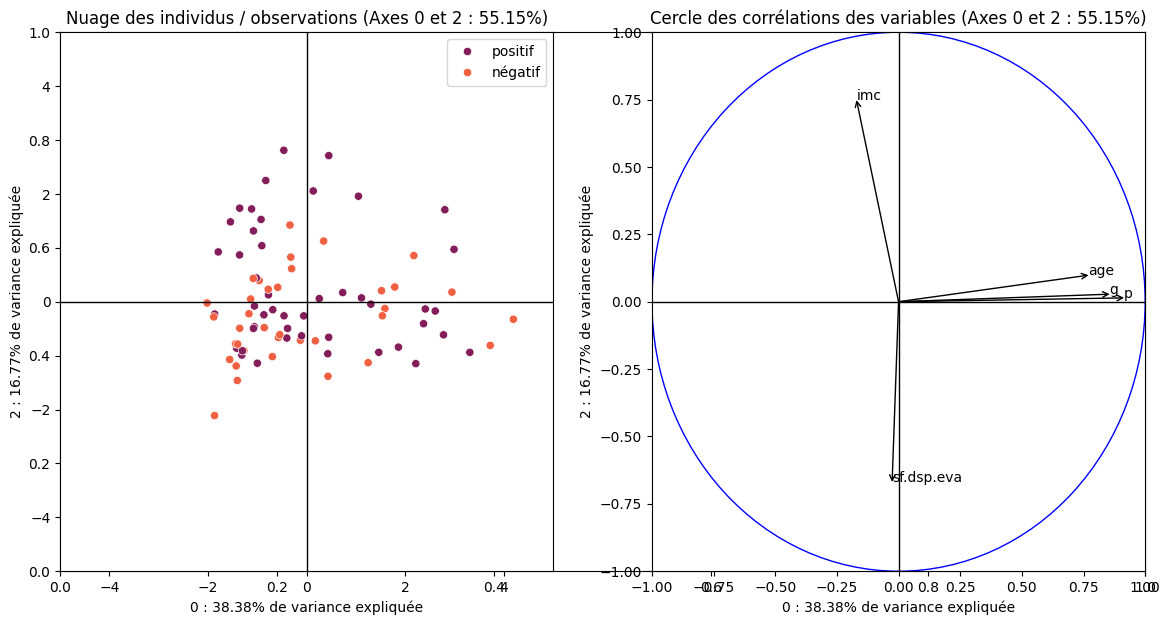

In [36]:
plot_pca(coord, X, Y, acp, 0, 2, True)

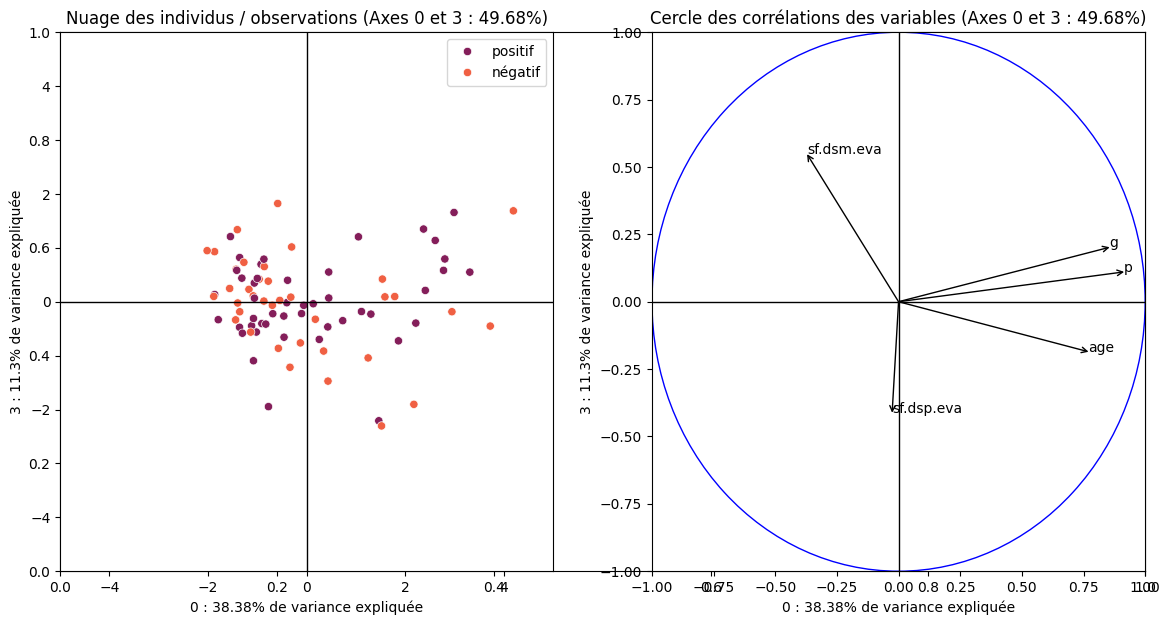

In [37]:
plot_pca(coord, X, Y, acp, 0, 3, True)

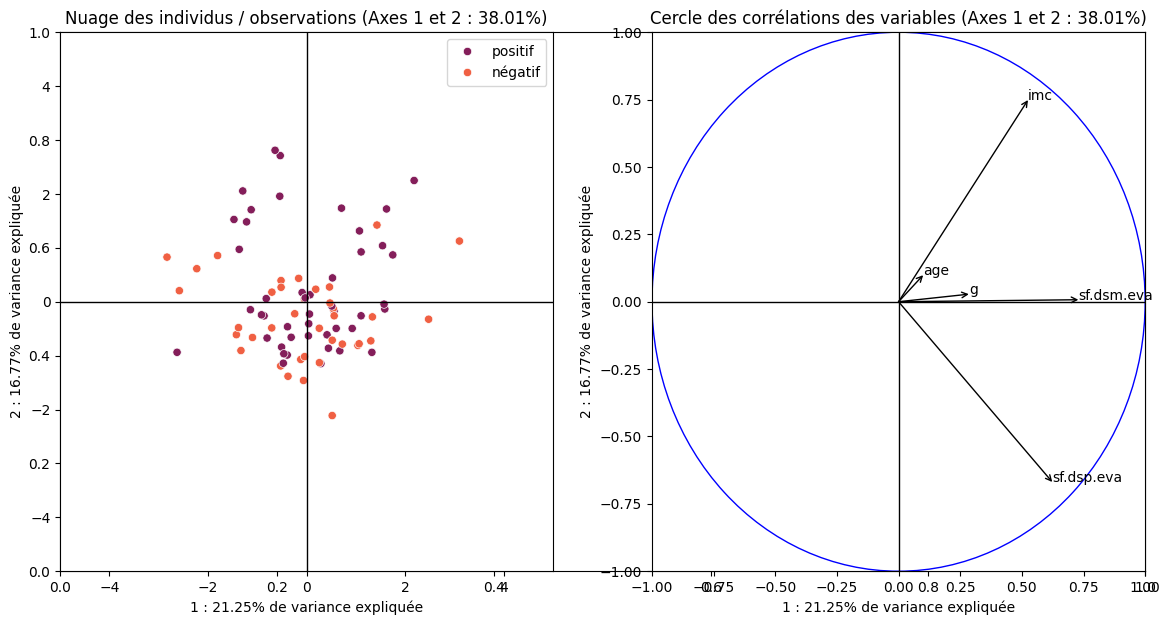

In [38]:
plot_pca(coord, X, Y, acp, 1, 2, True)

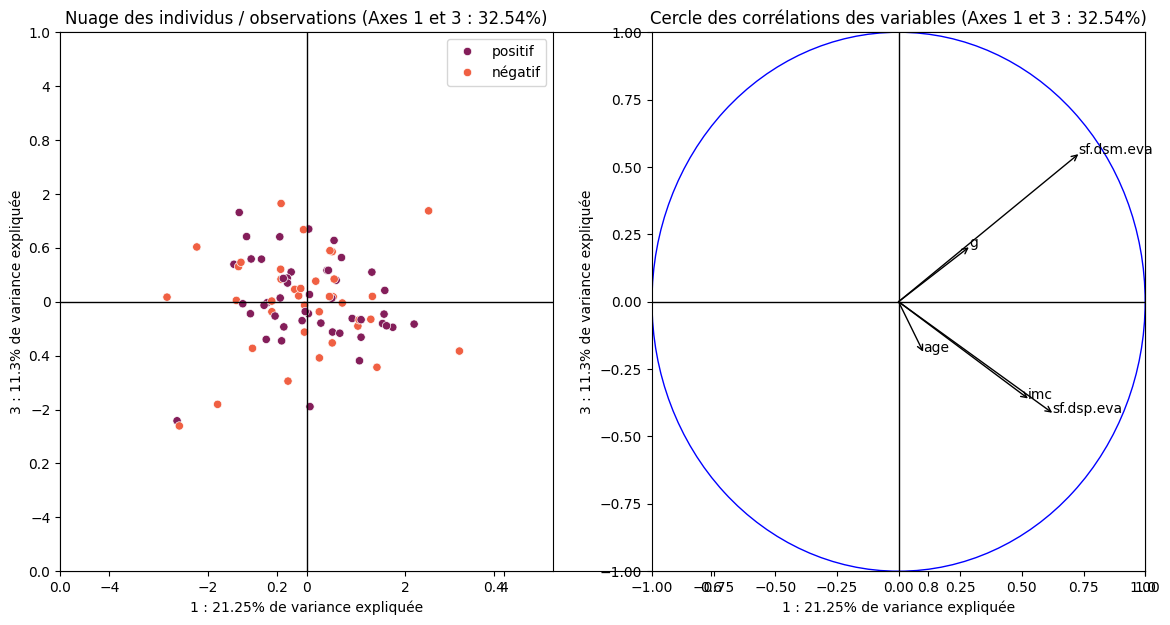

In [39]:
plot_pca(coord, X, Y, acp, 1, 3, True)

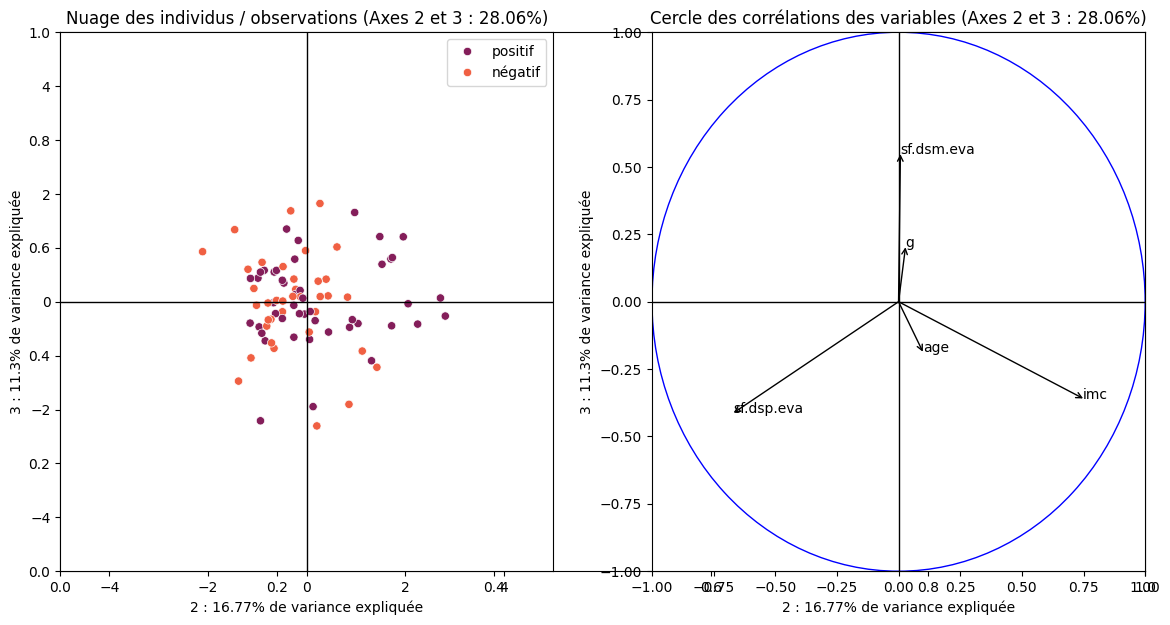

In [40]:
plot_pca(coord, X, Y, acp, 2, 3, True)

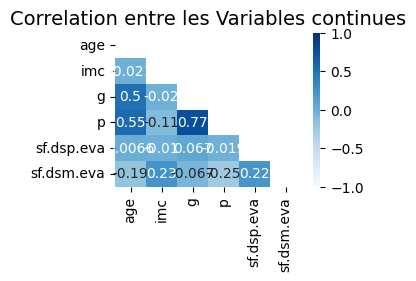

In [41]:
recueil_imc.loc[:, ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']]


plt.figure(figsize=(3,2))
plt.style.use('default')

mask = np.triu(np.ones_like(recueil_imc.loc[:, ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']].corr()))
sns.heatmap(recueil_imc.loc[:, ['age', 'imc', 'g', 'p', 'sf.dsp.eva', 'sf.dsm.eva']].corr(),cmap="Blues", annot=True, mask=mask, cbar=True, vmin=-1, vmax=1)
plt.yticks(rotation=0)

plt.title("Correlation entre les Variables continues", size=14)
# plt.text(10, 0.5, 'Source : A METTRE ICI')
plt.show();

# MCA :

In [42]:
#On crée les deux versions des dataframes (ONE_enc, ou inchangé)
features_cat_enc, features_cont = preprocess(features, baseline=True)
features_cat_enc_2, features_cont_2 = preprocess(features, baseline=False)

In [43]:
features

,chir,age,imc,g,p,atcd.endo,atcd.chir.oma,atcd.fibrome,atcd.chir.endo,atcd.infertilite,...,irm.vagin,irm.kissing,irm.adherences,irm.retroversion,irm.epanchement,irm.opac.vagin,irm.opac.rectum,irm.xr,irm.externe,avis.dig/uro
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
JJ-002,SW,36,21.6,5,3,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0
VH-014,GD,37,19.1,0,0,1,0,0,0,1,...,1,0,1,0,0,1,1,1,0,1
DS-015,SW,49,19.1,2,2,1,1,0,1,0,...,0,0,0,0,0,1,1,1,0,1
GC-021,CAP,42,35.4,4,0,0,1,0,0,1,...,0,0,1,0,0,1,1,1,0,0
MJ-026,SW,32,23.3,0,0,1,0,0,1,0,...,0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LF-194,GD,24,27.0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,0,0
TC-195,GD,43,23.0,2,1,1,0,0,1,1,...,0,0,0,0,0,1,1,1,0,1
HZ-196,GD,25,31.6,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,0


In [44]:
features_cat_enc.shape

(83, 67)

In [46]:
import prince
mca = prince.MCA(n_components=80,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='sklearn',           # Nicolai 18.96.2024: was 'auto' before, but invalid value. Changed to 'sklearn'
     random_state=42)
mca = mca.fit(features_cat_enc)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [ ]:
mca.row_coordinates(features_cat_enc)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
Numéro anonymat,,,,,,,,,,,,,,,,,,,,,
JJ-002,-0.319692,-0.128042,0.076320,-0.051767,0.201237,-0.219829,0.060201,-0.063682,0.232698,0.143817,...,-0.004404,-0.015302,-0.003772,0.007807,0.000110,-0.002118,-0.974507,-0.101877,-0.001748,-0.001973
VH-014,1.358376,-0.295410,0.305415,0.189617,-0.194914,-0.612004,0.228731,0.422470,0.208962,-0.325868,...,0.002741,-0.002947,0.000384,-0.000285,0.000103,0.000031,-0.974507,-0.101877,-0.001748,-0.001973
DS-015,0.850135,-0.025541,0.278814,0.160498,-0.139555,0.044682,-0.454656,0.011826,0.596352,0.224369,...,-0.009429,0.006701,-0.000538,0.000654,-0.000187,-0.000048,-0.974507,-0.101877,-0.001748,-0.001973
GC-021,0.275307,-0.635359,-0.557089,-0.009155,0.519477,0.286628,0.308249,-0.339546,-0.009268,-0.257622,...,-0.009960,0.006052,-0.003687,0.006504,-0.003949,0.000204,-0.974507,-0.101877,-0.001748,-0.001973
MJ-026,-0.032526,0.071579,-0.039156,-0.072162,-0.362999,0.317716,-0.008190,0.166687,0.012442,-0.026610,...,0.016636,0.023596,0.010692,-0.012589,-0.004498,-0.002092,-0.974507,-0.101877,-0.001748,-0.001973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LF-194,0.034529,-0.151779,0.252071,-0.051081,0.548654,0.176915,-0.125497,0.057811,-0.041334,-0.051322,...,0.036122,0.019257,-0.007396,-0.009837,-0.002184,-0.002100,-0.974507,-0.101877,-0.001748,-0.001973
TC-195,0.639889,0.064886,0.091650,-0.120750,-0.024135,0.230221,-0.201762,-0.222824,-0.179210,-0.019108,...,0.003657,-0.017854,0.007723,0.000036,0.004017,0.000559,-0.974507,-0.101877,-0.001748,-0.001973
HZ-196,-0.071211,-0.018317,0.319776,-0.163970,0.325913,0.051362,-0.021663,0.155639,-0.080258,-0.061160,...,-0.029217,0.011807,0.012188,0.000156,0.001691,0.002796,-0.974507,-0.101877,-0.001748,-0.001973


In [ ]:
mca.column_coordinates(features_cat_enc)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
chir_CAP,0.003050,-0.109209,-0.729710,-0.156816,-0.379079,-0.326355,0.175826,0.037684,0.016778,0.373043,...,-0.005273,0.011375,-0.018820,0.007252,0.000039,-0.000344,0.999993,0.003699,-0.000014,-0.000328
chir_GD,0.382125,0.184274,0.263544,0.006780,0.310350,0.194745,-0.416031,0.034770,-0.373185,-0.077420,...,-0.021882,-0.004234,-0.003407,-0.003392,-0.001631,-0.001072,0.999993,0.003699,-0.000014,-0.000328
chir_JC,-0.345530,-1.714749,-1.988717,-0.627215,2.036028,3.367034,0.784750,1.414302,1.846041,-0.009449,...,-0.014498,-0.101314,-0.022452,0.007439,0.000906,-0.008399,0.999993,0.003699,-0.000014,-0.000328
chir_PSH,-0.484364,1.654518,-0.335472,-0.981033,0.647275,-0.428589,0.720249,-0.800938,0.169933,-0.853606,...,0.027336,0.010466,0.003445,0.020319,0.008591,0.009125,0.999993,0.003699,-0.000014,-0.000328
chir_RW,-0.406492,0.581753,-0.150990,-0.808504,0.781823,0.355752,0.865944,2.388731,0.086459,0.548637,...,-0.084454,0.003969,0.033388,-0.046239,0.008974,0.004915,0.999993,0.003699,-0.000014,-0.000328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
irm.xr_positif,0.127455,-0.365490,0.388065,-0.189034,-0.053508,-0.084475,0.039513,-0.292867,-0.062190,0.148029,...,0.005582,0.006400,-0.024201,0.001613,0.006357,0.003891,0.999993,0.003699,-0.000014,-0.000328
irm.externe_negatif,0.119847,-0.341564,0.390034,-0.206007,-0.060841,-0.074895,0.049526,-0.282344,-0.058888,0.126017,...,-0.006410,-0.009237,0.029951,-0.000953,-0.003507,-0.002770,0.999993,0.003699,-0.000014,-0.000328
irm.externe_positif,-0.223164,0.636016,-0.726271,0.383599,0.113291,0.139460,-0.092221,0.525744,0.109654,-0.234652,...,0.011935,0.017199,-0.055771,0.001774,0.006530,0.005158,0.999993,0.003699,-0.000014,-0.000328
avis.dig/uro_negatif,-0.294837,-0.060552,-0.045393,0.008826,0.011707,0.016279,-0.022827,0.034275,-0.121895,-0.108227,...,-0.000643,-0.001577,-0.001072,-0.004297,0.000460,-0.000299,0.999993,0.003699,-0.000014,-0.000328


In [ ]:
mca.total_inertia_

np.float64(1.164179104477619)

In [ ]:
help(mca)

Help on MCA in module prince.mca object:

class MCA(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin, prince.ca.CA)
 |  MCA(n_components=2, n_iter=10, copy=True, check_input=True, random_state=None, engine='sklearn', one_hot=True)
 |  
 |  Method resolution order:
 |      MCA
 |      sklearn.base.BaseEstimator
 |      sklearn.utils._estimator_html_repr._HTMLDocumentationLinkMixin
 |      sklearn.utils._metadata_requests._MetadataRequester
 |      sklearn.base.TransformerMixin
 |      sklearn.utils._set_output._SetOutputMixin
 |      prince.ca.CA
 |      prince.utils.EigenvaluesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_components=2, n_iter=10, copy=True, check_input=True, random_state=None, engine='sklearn', one_hot=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  column_coordinates(self, X)
 |      The column principal coordinates.
 |  
 |  column_cosine_similarities(self, X)
 |      Return the c

In [ ]:
np.sum([ x*100 for x in mca.explained_inertia_]) # Does not run

AttributeError: 'MCA' object has no attribute 'explained_inertia_'

In [ ]:
features_cat_enc.shape

(83, 67)

In [ ]:
np.sum(mca.eigenvalues_)

np.float64(1.1641791044776113)

In [ ]:
ax = mca.plot_coordinates( # Does not work
     X=features_cat_enc,
     ax=None,
     figsize=(20, 20),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=50,
     show_column_labels=True,
     legend_n_cols=5)

AttributeError: 'MCA' object has no attribute 'plot_coordinates'

In [ ]:
(mca.col_masses_*100) # TODO research

chir_CAP                0.341665
chir_GD                 0.539471
chir_JC                 0.017982
chir_PSH                0.071930
chir_RW                 0.017982
                          ...   
irm.xr_positif          0.953066
irm.externe_negatif     0.971048
irm.externe_positif     0.521489
avis.dig/uro_negatif    1.258766
avis.dig/uro_positif    0.233771
Length: 145, dtype: float64

In [ ]:
mca2 = prince.MCA(n_components=10,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='sklearn',
     random_state=42)
mca2 = mca2.fit(features_cat_enc_2)

In [ ]:
mca2.total_inertia_

1.1358024691358024

In [ ]:
np.sum(mca2.explained_inertia_)

0.466500667294527

In [ ]:
mca2.explained_inertia_

[0.07160411124761197,
 0.06302065634367836,
 0.053459937057091005,
 0.04719068282274789,
 0.04541962345701628,
 0.042369835627796976,
 0.03963960336396177,
 0.03638932951497436,
 0.03461974552630633,
 0.03278714233334207]

In [ ]:
pd.DataFrame(mca.U_)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.115236,-0.053209,0.033480,-0.023289,0.095577,-0.104708,0.031537,-0.033618,0.130808,0.083076,...,-0.033019,-0.132552,-0.044294,0.149699,0.003730,-0.129873,0.108049,0.440941,0.000000,-0.000000
1,0.489640,-0.122760,0.133978,0.085304,-0.092574,-0.291507,0.119823,0.223021,0.117466,-0.188238,...,0.020549,-0.025531,0.004512,-0.005461,0.003490,0.001893,0.109763,0.000427,0.000044,-0.000073
2,0.306439,-0.010614,0.122309,0.072204,-0.066281,0.021283,-0.238176,0.006243,0.335232,0.129607,...,-0.070695,0.058043,-0.006315,0.012541,-0.006315,-0.002943,0.109763,0.000427,0.000044,-0.000073
3,0.099237,-0.264028,-0.244381,-0.004119,0.246725,0.136526,0.161479,-0.179246,-0.005210,-0.148816,...,-0.074669,0.052423,-0.043298,0.124712,-0.133592,0.012514,0.109288,0.098498,-0.029167,-0.101542
4,-0.011724,0.029745,-0.017177,-0.032464,-0.172406,0.151333,-0.004291,0.087994,0.006994,-0.015371,...,0.124724,0.204397,0.125568,-0.241406,-0.152139,-0.128278,0.108340,0.350417,-0.216547,-0.130580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.012446,-0.063073,0.110578,-0.022980,0.260583,0.084267,-0.065743,0.030518,-0.023235,-0.029646,...,0.270815,0.166810,-0.086859,-0.188620,-0.073873,-0.128785,0.109835,-0.036581,0.243595,-0.097761
79,0.230654,0.026964,0.040205,-0.054322,-0.011463,0.109658,-0.105695,-0.117629,-0.100741,-0.011038,...,0.027415,-0.154658,0.090699,0.000689,0.135887,0.034298,0.109470,0.074655,-0.077907,-0.008036
80,-0.025669,-0.007612,0.140278,-0.073766,0.154792,0.024464,-0.011349,0.082162,-0.045116,-0.035329,...,-0.219044,0.102274,0.143132,0.002998,0.057190,0.171466,0.110167,-0.060636,-0.214297,0.199084
81,-0.077122,0.021960,0.126207,0.068601,0.037390,-0.137895,-0.023652,0.103348,-0.035542,0.056440,...,0.091738,-0.106564,0.060950,-0.087540,-0.068026,0.040482,0.109495,0.013412,0.083012,-0.147767


In [ ]:
pd.DataFrame(mca.V_).sum(axis=1)

0      1.332455
1      0.009983
2     -1.160237
3      2.016687
4      0.742328
        ...    
75     0.625910
76   -10.379477
77    -1.081641
78    -0.151510
79     0.283147
Length: 80, dtype: float64

In [ ]:
(mca2.col_masses_*100).sort_values()

spec.nodule_positif                0.014874
sf.ombilic_positif                 0.014874
chir_RW                            0.014874
chir_JC_positif                    0.014874
chir_JC                            0.014874
                                     ...   
spec.nodule_negatif                1.219694
chir_RW_negatif                    1.219694
chir_JC_negatif                    1.219694
sf.ombilic_negatif                 1.219694
sf.dsp.type_orificielle_negatif    1.219694
Length: 173, dtype: float64

In [ ]:
(mca2.col_masses_*100).sort_values()

spec.nodule_positif                0.014874
sf.ombilic_positif                 0.014874
chir_RW                            0.014874
chir_JC_positif                    0.014874
chir_JC                            0.014874
                                     ...   
spec.nodule_negatif                1.219694
chir_RW_negatif                    1.219694
chir_JC_negatif                    1.219694
sf.ombilic_negatif                 1.219694
sf.dsp.type_orificielle_negatif    1.219694
Length: 173, dtype: float64

In [ ]:
(mca2.col_masses_*100).sort_values()

spec.nodule_positif                0.014874
sf.ombilic_positif                 0.014874
chir_RW                            0.014874
chir_JC_positif                    0.014874
chir_JC                            0.014874
                                     ...   
spec.nodule_negatif                1.219694
chir_RW_negatif                    1.219694
chir_JC_negatif                    1.219694
sf.ombilic_negatif                 1.219694
sf.dsp.type_orificielle_negatif    1.219694
Length: 173, dtype: float64

In [ ]:
mca2.explained_inertia_

[0.07160411124761197,
 0.06302065634367836,
 0.053459937057091005,
 0.04719068282274789,
 0.04541962345701628,
 0.042369835627796976,
 0.03963960336396177,
 0.03638932951497436,
 0.03461974552630633,
 0.03278714233334207]

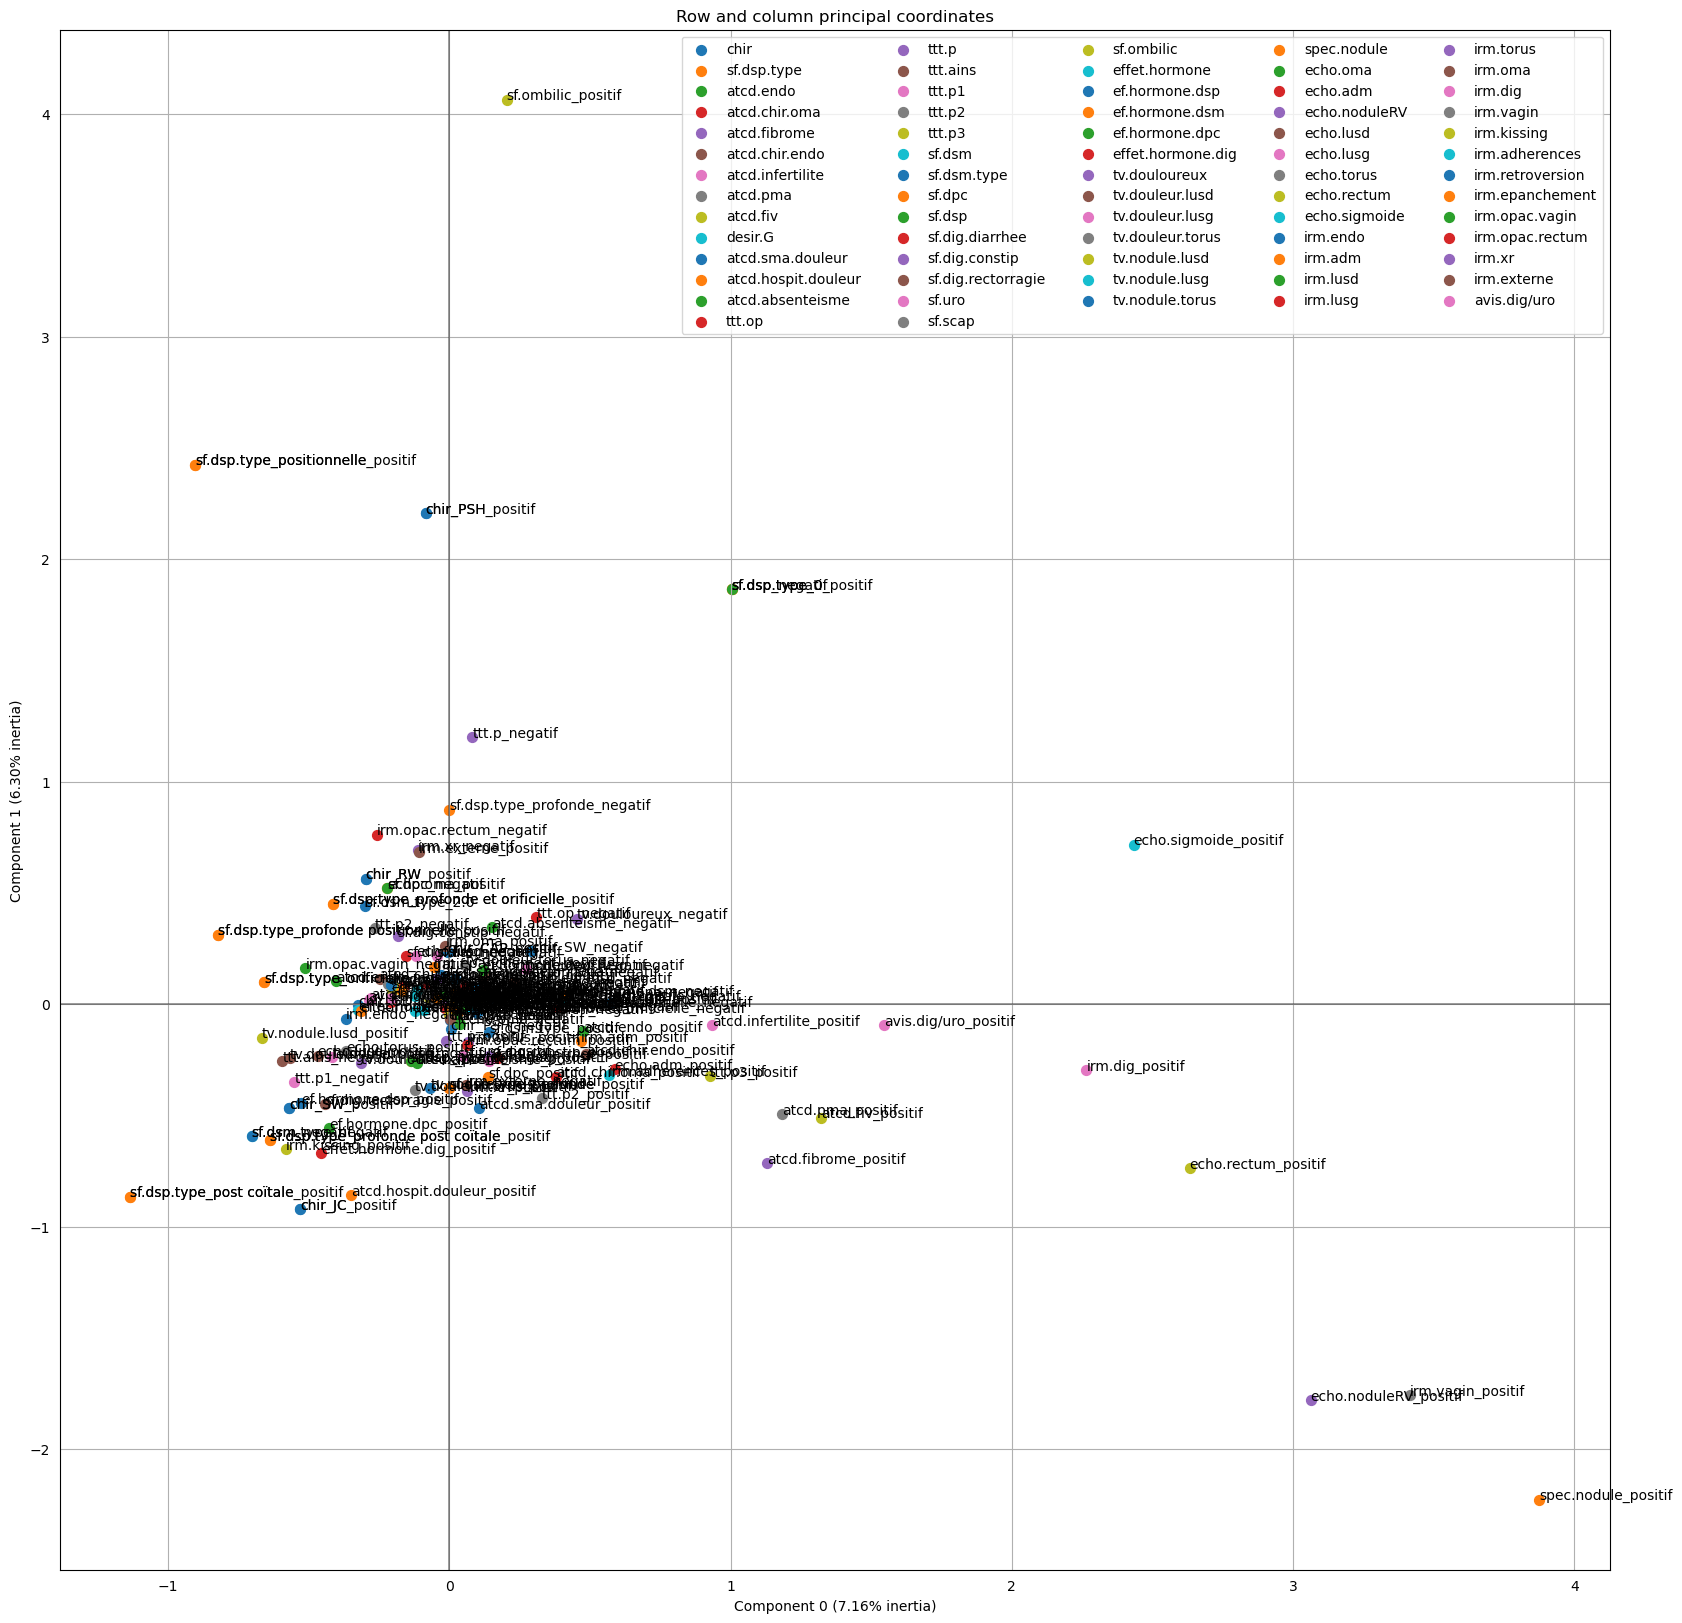

In [ ]:
ax = mca2.plot_coordinates(
     X=features_cat_enc_2,
     ax=None,
     figsize=(20, 20),
     show_row_points=False,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=50,
     show_column_labels=True,
     legend_n_cols=5)